Load necessary libraries.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import json
import html
import sys
figure = 0

In this assignment, we will use RNN neural network with one input layer (as many nodes as characters in alphabet), 1 hidden layer (with *tanh* as activation function), and one output layer  (as many nodes as characters in alphabet and *SoftMax* as activation function) with the loss function cross entropy (classification metric) over a sequence of characters. Then, we will train this network using sequence of characters from the book *The Goblet of Fire* by J.K. Rowling and Trump tweets, by using as target of each input character its following character in the text (like a moving window).

## Exercise 1: Implement and train a vanilla RNN

### 0.1 Read in the data

The text is loaded as a string and contains 1107540 characters.

In [2]:
book_data = open('goblet_book.txt', 'r').read()
type(book_data), len(book_data)

(str, 1107540)

These are the first 1000 characters of the text, first raw and then printed (without tabs '\t', linebreaks '\ln', etc).

In [3]:
book_data[0:1000]

'HARRY POTTER AND THE GOBLET OF FIRE\n\nCHAPTER ONE - THE RIDDLE HOUSE\n\n\tThe villagers of Little Hangleron still called it "the Riddle House," even though it had been many years since the Riddle family had lived there.  It stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face.  Once a fine-looking manor, and easily the largest and grandest building for miles around, the Riddle House was now damp, derelict, and unoccupied.\n\tThe Little Hagletons all agreed that the old house was "creepy."  Half a century ago, something strange and horrible had happened there, something that the older inhabitants of the village still liked to discuss when topics for gossip were scarce.  The story had been picked over so many times, and had been embroidered in so many places, that nobody was quite sure what the truth was anymore.  Every version of the tale, however, started in the same place:  Fifty years before, at

In [4]:
print(book_data[0:1000])

HARRY POTTER AND THE GOBLET OF FIRE

CHAPTER ONE - THE RIDDLE HOUSE

	The villagers of Little Hangleron still called it "the Riddle House," even though it had been many years since the Riddle family had lived there.  It stood on a hill overlooking the village, some of its windows boarded, tiles missing from its roof, and ivy spreading unchecked over its face.  Once a fine-looking manor, and easily the largest and grandest building for miles around, the Riddle House was now damp, derelict, and unoccupied.
	The Little Hagletons all agreed that the old house was "creepy."  Half a century ago, something strange and horrible had happened there, something that the older inhabitants of the village still liked to discuss when topics for gossip were scarce.  The story had been picked over so many times, and had been embroidered in so many places, that nobody was quite sure what the truth was anymore.  Every version of the tale, however, started in the same place:  Fifty years before, at daybrea

Define a set containing the unique characters in the text. Its length K corresponds to the dimensionality of the output (and input) vector of our RNN.

In [5]:
book_chars = set(book_data)
K = len(book_chars)

Initialize map containers (Python dictionaries) and fill in the characters with the respective index in our alphabet.

In [6]:
char_to_ind, ind_to_char = dict(), dict()
for index, character in enumerate(book_chars):
    char_to_ind[character] = index
    ind_to_char[index] = character

In [7]:
char_to_ind

{'H': 0,
 'f': 1,
 ' ': 2,
 'u': 3,
 'Q': 4,
 '4': 5,
 '.': 6,
 'w': 7,
 'q': 8,
 '2': 9,
 'c': 10,
 'C': 11,
 ')': 12,
 '_': 13,
 'p': 14,
 'h': 15,
 'G': 16,
 '/': 17,
 'Z': 18,
 'n': 19,
 '6': 20,
 'o': 21,
 '!': 22,
 'K': 23,
 'L': 24,
 'm': 25,
 '\n': 26,
 '-': 27,
 '0': 28,
 'D': 29,
 'b': 30,
 'k': 31,
 'g': 32,
 '7': 33,
 '^': 34,
 'j': 35,
 'R': 36,
 'd': 37,
 'x': 38,
 'S': 39,
 '1': 40,
 '9': 41,
 'P': 42,
 'N': 43,
 'W': 44,
 'O': 45,
 ';': 46,
 'e': 47,
 'B': 48,
 '\t': 49,
 '(': 50,
 ',': 51,
 'y': 52,
 't': 53,
 'l': 54,
 's': 55,
 'Y': 56,
 'U': 57,
 'r': 58,
 ':': 59,
 'X': 60,
 '3': 61,
 'z': 62,
 'I': 63,
 'T': 64,
 'F': 65,
 'i': 66,
 "'": 67,
 'J': 68,
 '}': 69,
 'V': 70,
 'v': 71,
 '"': 72,
 'A': 73,
 'M': 74,
 'E': 75,
 'a': 76,
 '?': 77}

## 0.2 Set hyper-parameters & initialize the RNN's parameters
## 0.3 Synthesize text from your randomly initialized RNN
## 0.4 Implement the forward & backward pass of back-prop

The following *RNN* Python class initialize the hyper-parameters matrix and contains the functions: *synthesize*, *forward*, *backward* and *train* with *AdaGrad* optimization.

- *synthesize*: Receives as input a vector *h0* (the hidden state at sequence time 0), another vector *x0* which will represent the first one hot input vector to our RNN (first character), and an integer *length* denoting the length of the sequence you want to generate. Then, iterates the sequence length applying the forward equations and with the generated output probability distribution samples a character (its integer/index) which will be the input character for next sequence iteration.


- *forward*: Receives a sequence $x$ of one hot input vectors (characters) and the hidden state *h0* at sequence time 0. These are the RNN forward equations:

$\quad \quad for \space t=1,..,length$

$\quad \quad \quad a^t_{[m,1]} = W_{[m,m]} \times h^{t-1}_{[m,1]} + U_{[m,d]} \times x^t_{[d,1]} + b_{[m,1]}$

$\quad \quad \quad h^t_{[m,1]} = tanh(a^t_{[m,1]}) \quad where \quad tanh(a^t_{ji})=\frac{exp(a^t_{ji})-exp(-a^t_{ji})}{exp(a^t_{ji})+exp(-a^t_{ji})}$

$\quad \quad \quad o^t_{[K,1]} = V_{[K,m]} \times h^t_{[m,1]} + c_{[K,1]}$

$\quad \quad \quad p^t_{[K,1]} = SoftMax\big(o^t_{[K,1]}\big) \quad where \quad SoftMax(o_{ji}^t)=\frac{exp(o_{ji}^t)}{\sum_{c=1}^K exp(o_{ci}^t)}$

&emsp;&emsp; where $d$ is the input size (number of alphabet characters), $m$ is the hidden layer size, and $K$ is the output size (number of alphabet characters).

- *backward*: Receives the inputs used in the *forward* function, its outputs $p$, $h$, $a$ which are the lists of final and intermediary vectors (by sequence iterations), and a sequence *y* of one hot output vectors (characters). These are the RNN backward equations:

&emsp;&emsp; with the loss function:

$\quad \quad L(x,y) = - \sum_{t=1}^{length} log\big({y^t_{[K,1]}}^T \times p^t_{[K,1]}\big)$

&emsp;&emsp; its gradients respect to each parameter are:

$\quad \quad \frac{\partial L}{\partial V} = \sum_{t=1}^{length} {g^t_{[1,K]}}^T \times {h^t_{[m,1]}}^T \quad where \quad g^t_{[1,K]}=\frac{\partial L}{\partial o^t}=-(y^t_{[K,1]}-p^t_{[K,1]})^T$

$\quad \quad \frac{\partial L}{\partial c} = \sum_{t=1}^{length} {g^t_{[1,K]}}^T$

$\quad \quad \frac{\partial L}{\partial h^t} = \bigg\{\begin{matrix} \frac{\partial L}{\partial o^t}V_{[K,m]} \quad if \quad t=length\\ \frac{\partial L}{\partial o^t}V_{[K,m]} + \frac{\partial L}{\partial a^{t+1}}W_{[m,m]} \quad if \quad 1\leq t<length\end{matrix}$

$\quad \quad \frac{\partial L}{\partial a^t} = \frac{\partial L}{\partial h^t} diag\big(1-tanh^2(a^t_{[m,1]})\big)_{[m,m]}$ 

$\quad \quad \frac{\partial L}{\partial W} = \sum_{t=1}^{length} {\frac{\partial L}{\partial a^t}}^T \times {h^{t-1}_{[m,1]}}^T$

$\quad \quad \frac{\partial L}{\partial U} = \sum_{t=1}^{length} {\frac{\partial L}{\partial a^t}}^T \times {x^t_{[d,1]}}^T$

$\quad \quad \frac{\partial L}{\partial b} = \sum_{t=1}^{length} {\frac{\partial L}{\partial a^t}}^T$

In [8]:
def one_hot(character_index, number_distinct_characters):
    character_one_hot = np.zeros(shape=(number_distinct_characters,1))
    character_one_hot[character_index,0] = 1
    
    return character_one_hot

class RNN(object):
    
    def __init__(self, input_size, hidden_size, output_size, scale=0.01, seed=1):
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Initialize the parameters matrix
        self.b = np.zeros((hidden_size,1))
        self.c = np.zeros((output_size,1))
        np.random.seed(seed)
        self.U = np.random.normal(size=(hidden_size,input_size), loc=0, scale=scale)
        self.W = np.random.normal(size=(hidden_size,hidden_size), loc=0, scale=scale)
        self.V = np.random.normal(size=(output_size,hidden_size), loc=0, scale=scale)

    def tanh(self, a):
        a = np.clip(a, -700, 700)
        
        return (np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    
    def softmax(self, o):
        o = np.clip(o, -700, 700)
        exponential_o = np.exp(o)
        p = exponential_o/exponential_o.sum(axis=0)
        
        return p

    def synthesize(self, x0, h0, length, stop_character_one_hot=None):
        Y = np.zeros(shape=(self.output_size,length))
        x = x0
        h_prev = h0
        for t in range(length):
            a = self.W@h_prev+self.U@x+self.b
            h = self.tanh(a)
            o = self.V@h+self.c
            p = self.softmax(o)

            # Create next sequence input randomly from predicted output distribution
            x = np.random.multinomial(1, np.squeeze(p))[:,np.newaxis]

            # Save the one-hot encoding of created next sequence input
            Y[:,[t]] = x[:,[0]]
            
            # Break loop if created next sequence input is equal to given stop character
            if all(x==stop_character_one_hot):
                Y = Y[:,0:(t+1)]
                break

            # Update previous hidden state for next sequence iteration
            h_prev = h

        return Y

    def forward(self, X, Y, h0):
        
        # Create empty lists for storing the final and intermediary vectors (by sequence iterations)
        seq_length = X.shape[1]
        p, o, h, a = [None]*seq_length, [None]*seq_length, [None]*seq_length, [None]*seq_length
        
        # Iterate the input sequence of one hot encoded characters
        loss = 0
        for t in range(seq_length):
            if t==0:
                a[t] = self.W@h0+self.U@X[:,[t]]+self.b
            else:
                a[t] = self.W@h[t-1]+self.U@X[:,[t]]+self.b
            h[t] = self.tanh(a[t])
            o[t] = self.V@h[t]+self.c
            p[t] = self.softmax(o[t])
            loss -= np.log(Y[:,[t]].T@p[t])[0,0]

        return loss, p, [h0]+h, a

    def backward(self, X, Y, p, h, a):
        
        # Extract initial hidden state (sequence time 0)
        h0 = h[0]
        h = h[1:]
        
        # Initialize the gradients matrix
        GRADS = dict()
        for parameter in ['b','c','W','U','V']:
            GRADS[parameter] = np.zeros_like(vars(self)[parameter])
        
        # Iterate inversively the input sequence of one hot encoded characters
        seq_length = X.shape[1]
        grad_a = [None]*seq_length
        for t in range((seq_length-1), -1, -1):
            g = -(Y[:,[t]]-p[t]).T
            GRADS['V'] += g.T@h[t].T
            GRADS['c'] += g.T
            if t<(seq_length-1):
                dL_h = g@self.V+grad_a[t+1]@self.W
            else:
                dL_h = g@self.V
            grad_a[t] = dL_h@np.diag(1-h[t][:,0]**2)
            if t==0:
                GRADS['W'] += grad_a[t].T@h0.T
            else:
                GRADS['W'] += grad_a[t].T@h[t-1].T
            GRADS['U'] += grad_a[t].T@X[:,[t]].T
            GRADS['b'] += grad_a[t].T

        # Clipping gradients
        for parameter in ['b','c','U','W','V']:
            GRADS[parameter] = np.clip(GRADS[parameter], -5, 5)

        return GRADS
    
    def train(self,
              text,
              ind_to_char,
              char_to_ind,
              seq_length,
              eta=0.1,
              number_updates=100000,
              max_epochs=np.inf,
              find_best_network=True,
              continue_previous_training=False,
              verbose=False,
              verbose_show_loss_frequency=1000,
              verbose_show_sample_frequency=10000,
              verbose_show_sample_length=200,
              verbose_show_sample_stop_character=None):
        
        # Check if any current update or smooth loss exist in the RNN class
        previous_update_or_loss_exist = True
        try:
            self.current_update
            self.smooth_loss
        except:
            previous_update_or_loss_exist = False
        
        # If not continuation of previous training...
        if not continue_previous_training or not previous_update_or_loss_exist:
            
            # Initialize current update and smooth loss list
            self.current_update = 1
            self.smooth_loss = []
            
            # Create AdaGrad memory parameters matrix
            for parameter in ['b','c','U','W','V']:
                vars(self)[parameter+'_memory'] = np.zeros_like(vars(self)[parameter])
            
            # Define minimum loss and initialize best network parameters matrix (if required)
            if find_best_network:
                self.smooth_loss_min = np.inf
                self.smooth_loss_min_update = 1
                for parameter in ['b','c','U','W','V']:
                    vars(self)[parameter+'_best'] = vars(self)[parameter]

        # Iterate updates
        current_epoch = 1
        while self.current_update<=number_updates:
            
            # Define the initial previous hidden state for next epoch (full text iteration)
            h_prev = np.zeros(shape=(self.hidden_size,1))

            # Iterate input text by blocks of seq_length characters
            for e in range(0, len(text)-1, seq_length):
                
                if e>len(text)-seq_length-1:
                    break

                # Generate the sequence data for the iteration (one hot encoding for each character)
                X_chars, Y_chars = text[e:(e+seq_length)], text[(e+1):(e+1+seq_length)]
                X = np.zeros(shape=(self.input_size,seq_length))
                Y = np.zeros(shape=(self.output_size,seq_length))
                for t in range(seq_length):
                    X[:,[t]] = one_hot(char_to_ind[X_chars[t]], self.output_size)
                    Y[:,[t]] = one_hot(char_to_ind[Y_chars[t]], self.output_size)

                # Forward and backward pass
                loss, p, h, a = self.forward(X, Y, h_prev)
                newGRADS = self.backward(X, Y, p, h, a)

                # Store smoothed loss
                if self.current_update==1:
                    self.smooth_loss.append(loss)
                else:
                    self.smooth_loss.append(0.999*self.smooth_loss[-1]+0.001*loss)

                # AdaGrad update step
                for parameter in ['b','c','U','W','V']:
                    vars(self)[parameter+'_memory'] += newGRADS[parameter]**2
                    vars(self)[parameter] += -eta*newGRADS[parameter]/ \
                        np.sqrt(vars(self)[parameter+'_memory']+np.spacing(1))
                
                # If best loss improved this network iteration parameters (if required)
                if find_best_network and self.smooth_loss[-1]<self.smooth_loss_min:
                    self.smooth_loss_min = self.smooth_loss[-1]
                    self.smooth_loss_min_update = self.current_update
                
                if verbose:
                    
                    # Show loss
                    shown_loss = False
                    if self.current_update%verbose_show_loss_frequency==0 or self.current_update==1:
                        shown_loss = True
                        print('Update '+str(self.current_update)+' with loss: '+ \
                              str(self.smooth_loss[-1]))
                        
                    # Show a synthesized sample
                    if self.current_update%verbose_show_sample_frequency==0 or self.current_update==1:
                        synthesize_one_hot = \
                            self.synthesize(x0=X[:,[0]], h0=h_prev, length=verbose_show_sample_length,
                                            stop_character_one_hot=verbose_show_sample_stop_character)
                        synthesize_characters = []
                        for index in range(synthesize_one_hot.shape[1]):
                            character = ind_to_char[np.where(synthesize_one_hot[:,index]>0)[0][0]]
                            synthesize_characters.append(character)
                        if shown_loss:
                            print('Synthesized sample:\n'+''.join(synthesize_characters)+'\n')
                        else:
                            print('Update '+str(self.current_update)+' with loss: '+ \
                                  str(self.smooth_loss[-1])+'\nSynthesized sample:\n'+ \
                                  ''.join(synthesize_characters)+'\n')
                    
                self.current_update += 1
                if self.current_update>number_updates:
                    break

                # Update the previous hidden state for next iteration
                h_prev = h[seq_length]

            current_epoch += 1
            if current_epoch>max_epochs:
                break
        
        # Update the final training parameters with the best stored network (if required)
        if find_best_network:
            for parameter in ['b','c','U','W','V']:
                vars(self)[parameter] = vars(self)[parameter+'_best']

### Checking gradients

Initialize the created class RNN with $m=100$ hidden layer size and $K=78$ input layer size (number of characters in our alphabet).

In [9]:
K = len(book_chars)
m = 100
myRNN = RNN(input_size=K, hidden_size=m, output_size=K)
myRNN.b.shape, myRNN.U.shape, myRNN.W.shape, myRNN.V.shape, myRNN.c.shape

((100, 1), (100, 78), (100, 100), (78, 100), (78, 1))

Let's use the first $seq\_length=25$ characters of the text as input $x$ and the next character in the book for each character as output $y$.

In [10]:
seq_length = 25
X_chars = book_data[0:seq_length]
Y_chars = book_data[1:(1+seq_length)]
X_chars, Y_chars

('HARRY POTTER AND THE GOBL', 'ARRY POTTER AND THE GOBLE')

Convert both character sequences $x$ and $y$ into one hot encoded vectors (matrix of $K$ rows and $seq\_length$ columns).

In [11]:
X = np.zeros(shape=(K,seq_length))
Y = np.zeros(shape=(K,seq_length))
for t in range(seq_length):
    X[:,[t]] = one_hot(character_index=char_to_ind[X_chars[t]], number_distinct_characters=K)
    Y[:,[t]] = one_hot(character_index=char_to_ind[Y_chars[t]], number_distinct_characters=K)

Compute the gradients with respect to the initialized parameters and created sequence.

In [12]:
h0 = np.zeros(shape=(myRNN.hidden_size,1))
loss, p, h, a = myRNN.forward(X, Y, h0)
newGRADS = myRNN.backward(X, Y, p, h, a)

#### Reformulating ComputeGradsNum.m in Python (numerically computed gradient with difference method)

In [13]:
def ComputeGradsNum(RNN, X, Y, h0, h=1e-4):
   
    # Iterate parameters and compute gradients numerically
    GRADS = dict()
    for parameter in ['b','c','U','W','V']:
        GRADS[parameter] = np.zeros_like(vars(RNN)[parameter])
        for i in range(vars(RNN)[parameter].shape[0]):
            for j in range(vars(RNN)[parameter].shape[1]):
                RNN_try = copy.deepcopy(RNN)
                vars(RNN_try)[parameter][i,j] += h
                loss2, _, _, _ = RNN_try.forward(X, Y, h0)
                vars(RNN_try)[parameter][i,j] -= 2*h
                loss1, _, _, _ = RNN_try.forward(X, Y, h0)
                GRADS[parameter][i,j] = (loss2-loss1)/(2*h)
    
    return GRADS

Compute the gradients numerically with respect to the initialized parameters and created sequence.

In [14]:
newGRADS_num = ComputeGradsNum(myRNN, X, Y, h0)

#### Compare the numerically and analitically computed gradients

We want to check that the gradients computed in the class function correspond to the correct gradients. To do this, we compare the gradient obtained by the network with the gradient computed with the difference method, after initializing the parameters as mentioned.

In [15]:
for parameter in ['b','c','U','W','V']:
    error = abs(newGRADS_num[parameter]-newGRADS[parameter])
    mean_error = np.mean(error<1e-6)
    max_error = error.max()
    print('For '+parameter+', the % of absolute errors <1e-6 is '+str(mean_error*100)+ \
          ' and the maximum is '+str(max_error))

For b, the % of absolute errors <1e-6 is 100.0 and the maximum is 6.557077381064147e-10
For c, the % of absolute errors <1e-6 is 100.0 and the maximum is 7.270448132423724e-10
For U, the % of absolute errors <1e-6 is 100.0 and the maximum is 3.70207003941303e-10
For W, the % of absolute errors <1e-6 is 100.0 and the maximum is 4.234456931146227e-10
For V, the % of absolute errors <1e-6 is 100.0 and the maximum is 4.3775381550306995e-10


# 0.5 Train your RNN using AdaGrad

The class RNN contains the *train* function which does the training using *AdaGrad* optimization method and receives as input a text, a sequence length for creating the characters sequence at each iteration, and a number of updates or epochs to iterate. As we are implementing SGD the loss from one training sequence to the next will vary a lot. Then, it is useful to keep track of a smoothed version of the loss over the iterations as:

$$smooth\_loss=0.999*smooth\_loss+0.001*loss$$

Note that in each forward and backward iteration, the previous hidden state *h0* is a zero vector in the first update of each epoch (full iteration of all text), and after that the hidden state of the last character in the previous iteration.

The equations for each *AdaGrad* update with learning rate $\eta$ are:

$\quad \quad for \space \theta=\{W,U,V,b,c\}:$

$\quad \quad \quad memory^{\space update}_{\theta} = memory^{\space update-1}_{\theta} + {\frac{\partial L}{\partial \theta^{\space update}}}^2$

$\quad \quad \quad \theta^{\space update+1} = \theta^{\space update}-\frac{\eta}{\sqrt{memory^{\space update}_{\theta}}} \frac{\partial L}{\partial \theta^{\space update}}$

Now, let's train our RNN with learning rate 0.1, 100.000 updates and sequence length 25.

In [16]:
myRNN.train(text=book_data,
            ind_to_char=ind_to_char,
            char_to_ind=char_to_ind,
            seq_length=25,
            eta=0.1,
            number_updates=100000,
            max_epochs=np.inf,
            find_best_network=True,
            continue_previous_training=False,
            verbose=True,
            verbose_show_loss_frequency=10000,
            verbose_show_sample_frequency=10000,
            verbose_show_sample_length=200,
            verbose_show_sample_stop_character=None)

Update 1 with loss: 108.91960099079333
Synthesized sample:
IUhMCWVc1Ae3I}E;iz"z/ctQ/df (zo_pBe)l.'_LVIzu}!kgR)eWFFqbKHYaF(A'jmTE",wx,^jP!/HDl4m!nyb}B

-wO.m4NVI0Kc17^JCL6SCl	'7YOfM-;n!cEmj)w}Yfd1Ib"-:G'M?0bI-Ga6yc'O/enfbf9ZuNuFI_s^IkrRBoC
odmL^9oHEAywjqmR FmT

Update 10000 with loss: 57.80571918340973
Synthesized sample:
tond  thery waretne FreracsAnyky the qonllyey pivone the kos tut, isdink.
"
	Harton bawse line tes.
Her vo woruigt bon't ofumery thabelleming ssing soutpens wher ith and e bis wiceld thas senese kedt?

Update 20000 with loss: 54.00974725778832
Synthesized sample:
Hardned. And nostireter in, iss as yee ane?  ".
""Wernoogtiring Harlye bort.
Yo weling Sot hom hoill waid he wo mamly fhatt ger Gan ath htas alich st him wall.
H"O hart, ray it hie stifne to forde cof

Update 30000 with loss: 52.10948981789396
Synthesized sample:
uthin Sfle wought head wald, seikih her and He.  "Treraround tar's ow yut kforey - the Pary.".. sughther, stich age has ate on ary ward das. Dourdu a

#### Visualization of the learning curve

In [17]:
def plot_learning_curve(smooth_loss, title='', length_text=None, seq_length=None):
    
    # Plot the learning curve
    _, ax = plt.subplots(1, 1, figsize=(15,5))
    plt.title('Learning curve '+title)
    ax.plot(range(1, len(smooth_loss)+1), smooth_loss)
        
    # Find the optimal metric value and the corresponding update
    optimal_update = np.argmin(smooth_loss)
    optimal_loss = np.round(smooth_loss[optimal_update], 4)
    label = 'Optimal training loss: '+str(optimal_loss)+' at update '+str(optimal_update+1)
    ax.axvline(optimal_update, c='green', linestyle='--', linewidth=1, label=label)
        
    # Plot vertical red lines each epoch (if required)
    if length_text is not None and seq_length is not None:
        updates_per_epoch = len([e for e in range(0, length_text-1, seq_length) \
                                 if e<=length_text-seq_length-1])
        for e in range(updates_per_epoch, len(smooth_loss)+1, updates_per_epoch):
            label = Epoch' if e==updates_per_epoch else ''
            ax.axvline(e, c='red', linestyle='--', linewidth=1, label=label)
        
    # Add axis, legend and grid
    ax.set_xlabel('Update step')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

This is the learning curve of the previous training.

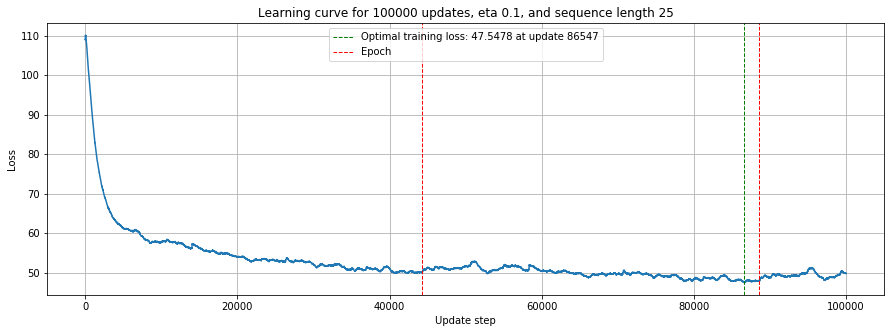

In [18]:
title = 'for 100000 updates, eta 0.1, and sequence length 25'
plot_learning_curve(myRNN.smooth_loss, title=title, length_text=len(book_data), seq_length=25)
plt.savefig('Figures/'+str(figure)+'_Curve_100000.png', bbox_inches='tight'); figure+=1

#### Synthesize a passage of length 1000 characters from our trained RNN

In [19]:
synthesize_one_hot = myRNN.synthesize(x0=X[:,[0]], h0=h0, length=1000)
synthesize_characters = []
for index in range(synthesize_one_hot.shape[1]):
    character = ind_to_char[np.where(synthesize_one_hot[:,index]>0)[0][0]]
    synthesize_characters.append(character)
print(''.join(synthesize_characters))

e rmucksed oumacon's your yut neasar as loch the core, sushice he drione, rischearte she Galpert!  Yedorands wexlise, in, qumpant the seares morwit in "Rot int'.  He hildun alley.
"No.  Ron juwt yout a the muene he sow you prake, leart, chtird tos hims at uce mowos ary, Howt had choS to Scouthing the Man o Domfy coutt pregeping fouthlly tryed the stalt criane.  "Try is the heeis, sep?  Harry ikan thou!"  said Glanck the to dut, titton, rerel?"
"Tount a was scoppinopenning sWeack he turtund me. NA with sightes, elficiunionor the opented, nooking and over and now and Harribley tow non themonge nowet," sowh the dent Coone the mouts it itt, have bey ming peates; that at to the beth, onting stomearrop cally her hay the stabbinmture and what slook frotway this rast!"
Tho Hes seulliogfightcaiss kner bet wa escey, ano" saims til sadd a peane tart, the slablled and pook ay beat, youch the on ine seepporide got speach the aslod a foony grousming," said -"
"D're gotle -roweblal meet eescald ase e

#### Continue the training for 200.000 updates more

In [20]:
myRNN.train(text=book_data,
            ind_to_char=ind_to_char,
            char_to_ind=char_to_ind,
            seq_length=25,
            eta=0.1,
            number_updates=100000+200000,
            max_epochs=np.inf,
            find_best_network=True,
            continue_previous_training=True,
            verbose=True,
            verbose_show_loss_frequency=50000,
            verbose_show_sample_frequency=50000,
            verbose_show_sample_length=200,
            verbose_show_sample_stop_character=None)

Update 150000 with loss: 48.496360751274466
Synthesized sample:
theseause tull, tho; yovet, Peoved - Aw his befpet. N"
Them, arlind heaggbled was welt wanked of exploiper the Gecar of agtlizew," shem shadly os in, applon's thew. Weeld there droupan verit and sagoi

Update 200000 with loss: 48.080461308088466
Synthesized sample:
um, Not. "Yout hew the Sogly for Pecuorout couring could gousned thom fast, the bood of I dart of the kno for Vashevery, this in it cam corouth frest he levang.
"Wery Moody bore very, ic midled woowes

Update 250000 with loss: 46.324554442432714
Synthesized sample:
ze raseednate norise wece tore loughor attontfonc whond Chat have roumpels amboutlith Lad-then frogeed his bace gat for dappestesss," said "saz was witele as hakely looked abloppraid rook to terurnoil

Update 300000 with loss: 45.68603621623406
Synthesized sample:
s he's month had beturttenconoom puckinst in the ond of he dadtle that worbong finds down, youen intiizand bode jome, and watcher, Bresen a

This is the learning curve of the previous training.

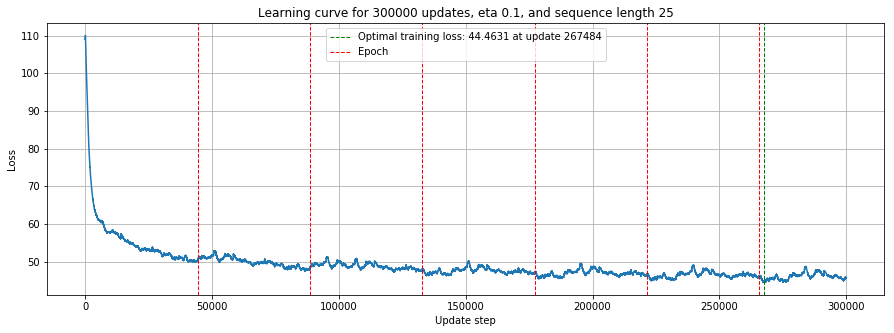

In [21]:
# Plot the learning curve
title = 'for 300000 updates, eta 0.1, and sequence length 25'
plot_learning_curve(myRNN.smooth_loss, title=title, length_text=len(book_data), seq_length=25)
plt.savefig('Figures/'+str(figure)+'_Curve_300000.png', bbox_inches='tight'); figure+=1

Let's synthesize another passage of length 1000 characters from our re-trained RNN.

In [22]:
synthesize_one_hot = myRNN.synthesize(x0=X[:,[0]], h0=h0, length=1000)
synthesize_characters = []
for index in range(synthesize_one_hot.shape[1]):
    character = ind_to_char[np.where(synthesize_one_hot[:,index]>0)[0][0]]
    synthesize_characters.append(character)
print(''.join(synthesize_characters))

EShiuld of lith; theisher of exerssed, compfinve, bednight's Hold in's dind Hey?"
"Dow ick to chis nots'rap steds has comeresed comit?" have weple jost ten, I Clave watthawd at bleagrold to alout wink would how. "Dary," looge. CJousk to.  Harry.
"You the word.  Them hinged.
"
"Mar peail seem, were oping speaway and smired the stive veet ican bound and shere of the quire went felt.  Cowen an and they houreTy haddne.
Cikau's sory!
""thapust the comess, thoseor just voulh ad acdarioussy....
"Loway by wis whee for when watel snaking reen go or wastnot cowhing it, get and endine the good with grounbe Dobul the naustan, you witht dying stitaken up bein, yencreast worrding, the to to Men'r ganes."

Ron the Me. UMan, coss youl rether to who Dide hisure thampaple the pofederobste in Pottsime up, ant, dasOm, no tenard bodned a rofe lougher thele in sagrinst though seak Enher, I reture in upus an a doned it the "Magbod.  No somecone down mirey a Frssy they vountongned toly youme as burry spat ben

# Exercise 2: Optional for bonus points

## Synthesize Donald Trump tweets instead of Harry Potter

Load the Trump tweets downloaded from https://github.com/bpb27/trump_tweet_data_archive.

In [23]:
files = ['condensed_2009.JSON','condensed_2010.JSON','condensed_2011.JSON','condensed_2012.JSON',
         'condensed_2013.JSON','condensed_2014.JSON','condensed_2015.JSON','condensed_2016.JSON',
         'condensed_2017.JSON','condensed_2018.JSON']
tweets = []
for file in files:
    with open(file) as open_file:
        tweets += [tweet['text'] for tweet in json.load(open_file)]

There are 36307 tweets from 2009 to 2018.

In [24]:
len(tweets)

36307

These are the first 5 tweets of Trump:

In [25]:
tweets[0:5]

['From Donald Trump: Wishing everyone a wonderful holiday & a happy, healthy, prosperous New Year. Let’s think like champions in 2010!',
 'Trump International Tower in Chicago ranked 6th tallest building in world by Council on Tall Buildings & Urban Habitat http://bit.ly/sqvQq',
 'Wishing you and yours a very Happy and Bountiful Thanksgiving!',
 "Donald Trump Partners with TV1 on New Reality Series Entitled, Omarosa's Ultimate Merger: http://tinyurl.com/yk5m3lc",
 '--Work has begun, ahead of schedule, to build the greatest golf course in history: Trump International – Scotland.']

Let's detect non common ASCII characters (e.g. emojis, Chinese characters, etc.) to reduce the dimensionality of the alphabet.

In [26]:
strange_ascii = dict()
for tweet in tweets:
    for character in tweet:
        if ord(character)<32 or ord(character)>126:
            strange_ascii[character] = ord(character)
strange_ascii

{'’': 8217,
 '–': 8211,
 '“': 8220,
 '”': 8221,
 '\n': 10,
 '‘': 8216,
 '\xa0': 160,
 '…': 8230,
 '\r': 13,
 '—': 8212,
 '£': 163,
 '―': 8213,
 'é': 233,
 '❤': 10084,
 '️': 65039,
 '😳': 128563,
 '👍': 128077,
 '«': 171,
 '»': 187,
 '🌚': 127770,
 'º': 186,
 '😢': 128546,
 '🇺': 127482,
 '🇸': 127480,
 '®': 174,
 '😂': 128514,
 '♡': 9825,
 'É': 201,
 '👌': 128076,
 '☺': 9786,
 '★': 9733,
 '♥': 9829,
 '👏': 128079,
 '\u200e': 8206,
 'è': 232,
 'Ｒ': 65330,
 'Ｔ': 65332,
 '☞': 9758,
 '💗': 128151,
 '💙': 128153,
 '\u200f': 8207,
 '🙏': 128591,
 '€': 8364,
 '💔': 128148,
 '😘': 128536,
 '😄': 128516,
 '📖': 128214,
 '🎉': 127881,
 '😍': 128525,
 '💯': 128175,
 '🔥': 128293,
 '💁': 128129,
 '💞': 128158,
 '☝': 9757,
 '💪': 128170,
 '✊': 9994,
 '😬': 128556,
 '™': 8482,
 '✌': 9996,
 '✈': 9992,
 '➡': 10145,
 '🗽': 128509,
 '🙌': 128588,
 '💰': 128176,
 '\x92': 146,
 '✔': 10004,
 '🏈': 127944,
 '🐘': 128024,
 '💕': 128149,
 '😑': 128529,
 '👑': 128081,
 '🌹': 127801,
 '💋': 128139,
 '🙅': 128581,
 '‼': 8252,
 '🍻': 127867,
 '⛳': 

Let's preprocess the tweets with the following steps:
- Replace tabs '\t' and linebreaks '\n' by spaces
- Filter out strange ASCII characters
- Decode html sequences
- Add start and stop characters as '\t' and '\n' respectively

In [27]:
def preprocess_tweet(tweet):
    tweet = tweet.replace('\t', ' ').replace('\n', ' ')
    tweet = ''.join(filter(lambda char: ord(char)>=32 and ord(char)<=126, tweet))
    tweet = html.unescape(tweet)
    tweet = '\t'+tweet+'\n'

    return tweet

tweets = [preprocess_tweet(tweet) for tweet in tweets]

Define a set containing the unique characters in the tweets. Its length K corresponds to the dimensionality of the output (and input) vector of our RNN.

In [28]:
tweets_chars = set(''.join(tweets))
K_Trump = len(tweets_chars)

Initialize map containers (Python dictionaries) and fill in the characters with the respective index in our alphabet.

In [29]:
char_to_ind_Trump = dict()
ind_to_char_Trump = dict()
for i, a in enumerate(tweets_chars):
    char_to_ind_Trump[a] = i
    ind_to_char_Trump[i] = a

In [30]:
char_to_ind_Trump

{' ': 0,
 'u': 1,
 '~': 2,
 '2': 3,
 '{': 4,
 '`': 5,
 'C': 6,
 'p': 7,
 '8': 8,
 'L': 9,
 '\n': 10,
 '7': 11,
 'd': 12,
 '9': 13,
 'W': 14,
 '%': 15,
 '|': 16,
 's': 17,
 'V': 18,
 '+': 19,
 '.': 20,
 'Q': 21,
 'w': 22,
 'Z': 23,
 'n': 24,
 'o': 25,
 '!': 26,
 '5': 27,
 'k': 28,
 'R': 29,
 'S': 30,
 ';': 31,
 '\t': 32,
 ',': 33,
 't': 34,
 '@': 35,
 ']': 36,
 'T': 37,
 'F': 38,
 "'": 39,
 '}': 40,
 '\\': 41,
 'v': 42,
 'M': 43,
 '1': 44,
 'A': 45,
 'E': 46,
 '>': 47,
 'H': 48,
 '4': 49,
 'q': 50,
 ')': 51,
 '_': 52,
 '6': 53,
 'm': 54,
 '-': 55,
 'D': 56,
 'b': 57,
 'g': 58,
 '#': 59,
 '[': 60,
 'j': 61,
 'N': 62,
 'e': 63,
 '(': 64,
 '<': 65,
 '$': 66,
 'Y': 67,
 'U': 68,
 'I': 69,
 'i': 70,
 'J': 71,
 '?': 72,
 'f': 73,
 'c': 74,
 '&': 75,
 'h': 76,
 'G': 77,
 '/': 78,
 'K': 79,
 '0': 80,
 'x': 81,
 'P': 82,
 '=': 83,
 'O': 84,
 'B': 85,
 '*': 86,
 'y': 87,
 'l': 88,
 'X': 89,
 '3': 90,
 'r': 91,
 ':': 92,
 'z': 93,
 '"': 94,
 'a': 95}

Create the one hot encoded vectors for the start and stop characters.

In [31]:
start_one_hot = one_hot(character_index=char_to_ind_Trump['\t'], number_distinct_characters=K_Trump)
end_one_hot = one_hot(character_index=char_to_ind_Trump['\n'], number_distinct_characters=K_Trump)

Initialize the created class RNN with $m=100$ hidden layer size and $K=92$ input layer size (number of characters in our tweets alphabet).

In [32]:
m_Trump = 100
myRNN_Trump = RNN(input_size=K_Trump, hidden_size=m_Trump, output_size=K_Trump)

Now, let's train our RNN with learning rate 0.1, 5 epochs (iteration of all tweets), sequence length 15, and suffling tweets order by epochs.

*Note*: Now we set the function parameters *number_updates* equal to infinite and *max_epochs* equal to 1, since we want to iterate once all the text of each tweet by epoch.

In [33]:
epochs = 5
for epoch in range(epochs):
    np.random.seed(epoch)
    tweets_shuffled = np.random.permutation(tweets)
    for t, tweet in enumerate(tweets_shuffled):
        
        # Show what tweet is being computed
        bar = '='*(50*(t+1)//len(tweets))
        msg = '\rEpoch '+str(epoch+1)+' tweet '+str(t+1)+'/'+str(len(tweets))+' [{:50s}]'
        sys.stdout.write(msg.format(bar))
        
        # Re-train the network with the tweet of the iteration 
        myRNN_Trump.train(text=tweet,
                          ind_to_char=ind_to_char_Trump,
                          char_to_ind=char_to_ind_Trump,
                          seq_length=15,
                          eta=0.1,
                          number_updates=np.inf,
                          max_epochs=1,
                          find_best_network=False,
                          continue_previous_training=True,
                          verbose=False,
                          verbose_show_loss_frequency=None,
                          verbose_show_sample_frequency=None,
                          verbose_show_sample_length=None,
                          verbose_show_sample_stop_character=None)
        
    print('\nSynthesized tweets:\n\n')
    for sample in range(3):
        synthesize_one_hot = \
            myRNN_Trump.synthesize(x0=start_one_hot, h0=np.zeros(shape=(myRNN_Trump.hidden_size,1)),
                                   length=140, stop_character_one_hot=end_one_hot)
        synthesize_characters = []
        for index in range(synthesize_one_hot.shape[1]):
            character = ind_to_char_Trump[np.where(synthesize_one_hot[:,index]>0)[0][0]]
            synthesize_characters.append(character)
        print(''.join(synthesize_characters)+'\n')

Epoch 1 tweet 36307/36307 [==================================================]
Synthesized tweets:


The Mame. #Calise that Jountiy & dWars @cotFUMrRLEichace. It demidect Barssgity may, 1 cornol to betticanify  Sawg oul sinly of @MIDAG Toums

@Obllab: he loonel a pleycatico D. Thanks in gederdary!  Thisk nathe. Tox Intting cauts stiloon treating @reassolls Standy queth fig alte. S

A-ngonuy #DonaldTrump Amragn Ama im http://t.cv/$5pYBAUVML hodesccalaU


Epoch 2 tweet 36307/36307 [==================================================]
Synthesized tweets:


@Barensenqooketam 


Cake wing, Donagars porte. You & af the engrity farw har hards mught an ard showen! Hight troeving be win tear an Helling in Amashs dree to 

.@jvarmarly long puing faine! He umatrendinally - Lo.n: do keppide is calld tracting- goea sumpice. Lead News govald #Blasintlyabladle  Thin

Epoch 3 tweet 36307/36307 [==================================================]
Synthesized tweets:


"@SecripaJlay, USA 754 & Good jent 

This is the learning curve of the previous training.

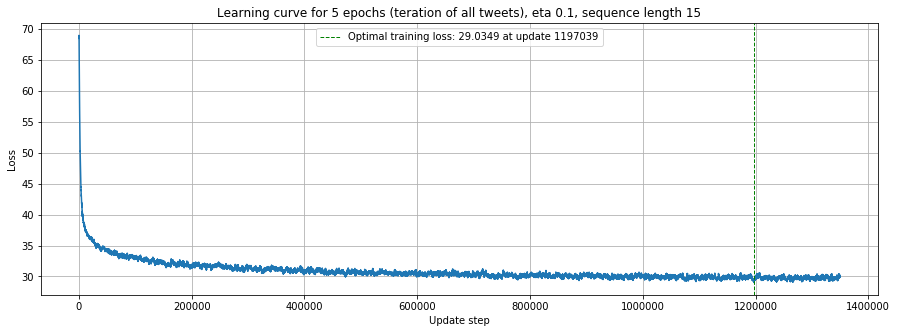

In [34]:
title = 'for 5 epochs (teration of all tweets), eta 0.1, sequence length 15'
plot_learning_curve(myRNN_Trump.smooth_loss, title=title, length_text=None, seq_length=None)
plt.savefig('Figures/'+str(figure)+'_Curve_Tweets.png', bbox_inches='tight'); figure+=1